# Plotting T & S properties

Producing plots of T and S of the CANARI-LE historic ensemble, modelled after fig 3 in Timmermans & Marshall (2020)

In [22]:
%%time
import dask_gateway
import dask
# Create a connection to dask-gateway.
gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")

# Inspect and change the options if required before creating your cluster.
options = gw.cluster_options()
options.worker_cores = 1 #keeping this at 1 and allowing 15 worker processes seems to run faster than the other way around
options.scheduler_cores = 1 #we need at least one core for the scheduler
#specify which conda env to use, this must match the versions of python and dask (and a few other libraries) used on the notebook service
options.worker_setup='source /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/bin/activate /gws/smf/j04/canari/dask-env'

# Create a dask cluster, or, if one already exists, connect to it.
# This stage creates the scheduler job in SLURM, so may take some time.
# While your job queues.
clusters = gw.list_clusters()
if not clusters:
    cluster = gw.new_cluster(options, shutdown_on_close=False)
else:
    cluster = gw.connect(clusters[0].name)

# Create at least one worker, and allow your cluster to scale to 15.
# The max JASMIN allows is 16, but one of these is used as the scheduler.
cluster.adapt(minimum=1, maximum=15)

# Get a dask client.
client = cluster.get_client()

CPU times: user 54.4 ms, sys: 30.4 ms, total: 84.8 ms
Wall time: 333 ms


2024-03-08 17:13:50,100 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [23]:
import coast
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
#import gsw_xarray as gsw

In [24]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

r_earth=6371e3

def add_density(ds):
    ds=ds.assign_coords({'p':gsw.p_from_z(-ds.deptht,ds.nav_lat)})
    ds['SA']=gsw.SA_from_SP(ds['vosaline'],ds.p,ds.nav_lon,ds.nav_lat)
    ds['CT']=gsw.CT_from_pt(ds['SA'],ds['votemper'])
    ds['rho']=gsw.rho(ds.SA,ds.CT,ds.p)
    return ds

In [25]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/OCN/yearly"
nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"

config_grid={}
config_dir="../../tutorials/config"
for grid in ['t','f','u','v']:
    config_grid[grid]=f'{config_dir}/example_nemo_grid_{grid}.json'

In [26]:
Tdata=[]
for year in range(1985,1986):
    temp_Tgrid = f"{data_path}/{year}/cv575o_1_mon__grid_T_votemper.nc"
    sal_Tgrid = f"{data_path}/{year}/cv575o_1_mon__grid_T_vosaline.nc"
    Tdata.append(xr.open_mfdataset([temp_Tgrid,sal_Tgrid]))
Tdata=xr.concat(Tdata,'time_counter')

/gws/smf/j04/canari/dask-env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 33.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/gws/smf/j04/canari/dask-env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 33.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


In [27]:
Tdata

<xarray.Dataset>
Dimensions:              (time_counter: 12, axis_nbounds: 2, deptht: 75,
                          y: 1207, x: 1442, nvertex: 4)
Coordinates:
  * time_counter         (time_counter) object 1985-01-16 00:00:00 ... 1985-1...
  * deptht               (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * y                    (y) float64 0.0 1.0 2.0 ... 1.205e+03 1.206e+03
  * x                    (x) float64 0.0 1.0 2.0 ... 1.44e+03 1.441e+03
    nav_lat              (y, x) float32 dask.array<chunksize=(1207, 1442), meta=np.ndarray>
    nav_lon              (y, x) float32 dask.array<chunksize=(1207, 1442), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex
Data variables:
    time_counter_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    deptht_bounds        (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    bounds_nav_lat       (time_counter, y, x, nvertex) float32 dask.array<chunksize=(12, 604, 721, 2), meta=np.ndarray>
    bounds_nav_lon       (time_counter, y, x, nvertex) float32 dask.array<chunksize=(12, 604, 721, 2), meta=np.ndarray>
    vosaline             (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 19, 302, 361), meta=np.ndarray>
    votemper             (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 19, 302, 361), meta=np.ndarray>
Attributes: (12/35)
    Conventions:            CF-1.10
    license:                
    institution:            NCAS
    realization_index:      1
    variant_id:             r1i1p2f1
    source_type:            AOGCM
    ...                     ...
    grid:                   Native eORCA025 tripolar primarily 1/4 deg grid; ...
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    parent_source_id:       CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3
    realm:                  ocean
    initialization_index:   1
    external_variables:     areacello

In [6]:
Tdata=add_density(Tdata.mean('time_counter'))

In [28]:
nemo_t = coast.Gridded(fn_data=Tdata, fn_domain=nemo_dom, config=config_grid['t'])

/gws/smf/j04/canari/dask-env/lib/python3.10/site-packages/coast/data/gridded.py:236: UserWarning: The model domain loaded, '/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc', does not contain the bathy_metry' variable. This will result in the NEMO.dataset.bathymetry variable being set to zero, which may result in unexpected behaviour from routines that require this variable.


In [85]:
# Manually find pole points between transects below
pole_points=[]
for lat in np.arange(89.3,90,0.1):
    pt=tuple(nemo_t.find_j_i(lat=lat,lon=-140))
    if pt not in pole_points:
        pole_points.append(pt)
for lat in np.arange(90,88.9,-0.1):
    pt=tuple(nemo_t.find_j_i(lat=lat,lon=40))
    if pt not in pole_points:
        pole_points.append(pt)
pole_points

[(1199, 390), (1201, 387), (1199, 1069)]

In [119]:
transects=[[(70,-170),(75, -140)],[(75, -140), (90,-140)],pole_points,[(90, 40), (81,40)]]

all_data=[]

r0=0
for transect in transects:
    if len(transect)==2:
        tran_t = coast.TransectT(nemo_t,  transect[0], transect[1])
        if transect[0][0]>transect[1][0]:
            tran_t.data=tran_t.data.sortby('latitude',ascending=False)
        dx=tran_t.data.longitude.diff('r_dim')*np.pi/180*r_earth*np.cos((tran_t.data.latitude[1:]*0.5+tran_t.data.latitude[:-1]*0.5)*np.pi/180)
        dy=tran_t.data.latitude.diff('r_dim')*np.pi/180*r_earth
    else:
        tran_t.data=xr.concat([Tdata.sel(x=pp[1],y=pp[0]) for pp in transect],'r_dim')
        tran_t.data=tran_t.data.rename({'nav_lat':'latitude','nav_lon':'longitude','time_counter':'time','deptht':'depth_0'})
        tran_t.data=tran_t.data.rename_dims({'time':'t_dim','depth_0':'z_dim'})
        xdiff=tran_t.data.longitude.diff('r_dim')
        ydiff=tran_t.data.latitude.diff('r_dim')
        dx=xr.zeros_like(xdiff)
        dy=xr.zeros_like(ydiff)
        for rp in range(0,len(xdiff['r_dim'])):
            if xdiff[rp]>10:
                dx[rp]=0
                dy[rp]=((90-tran_t.data.latitude[rp])*np.pi/180*r_earth+(90-tran_t.data.latitude[rp+1])*np.pi/180*r_earth).data
            else:
                dx[rp]=(xdiff[rp]*np.pi/180*r_earth*np.cos((tran_t.data.latitude[rp]*0.5+tran_t.data.latitude[rp+1]*0.5)*np.pi/180)).data
                dy[rp]=(ydiff[rp]*np.pi/180*r_earth).data
    dr2=dx**2+dy**2
    dr=dr2**0.5
    rr=dr.cumsum()+r0
    tran_t.data=tran_t.data.assign_coords({'distance':(['r_dim',],[r0]+list(rr.data))})
    r0=rr[-1].data
    
   # print(tran_t.data.latitude.max().load())
    all_data.append(tran_t.data)

all_data=xr.concat(all_data,'r_dim')
all_data

<xarray.Dataset>
Dimensions:              (t_dim: 12, axis_nbounds: 2, r_dim: 412, z_dim: 75,
                          nvertex: 4)
Coordinates:
  * time                 (t_dim) object 1985-01-16 00:00:00 ... 1985-12-16 00...
    y                    (r_dim) float64 1.05e+03 1.051e+03 ... 1.161e+03
    x                    (r_dim) float64 446.0 446.0 ... 1.129e+03 1.129e+03
    longitude            (r_dim) float32 dask.array<chunksize=(120,), meta=np.ndarray>
    latitude             (r_dim) float32 dask.array<chunksize=(120,), meta=np.ndarray>
  * depth_0              (z_dim) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    distance             (r_dim) float64 0.0 1.462e+04 ... 5.235e+06 5.248e+06
Dimensions without coordinates: t_dim, axis_nbounds, r_dim, z_dim, nvertex
Data variables: (12/14)
    time_counter_bounds  (t_dim, axis_nbounds, r_dim) object dask.array<chunksize=(1, 2, 120), meta=np.ndarray>
    deptht_bounds        (t_dim, z_dim, axis_nbounds, r_dim) float32 dask.array<chunksize=(12, 75, 2, 120), meta=np.ndarray>
    bounds_nav_lat       (t_dim, r_dim, nvertex) float32 dask.array<chunksize=(12, 120, 2), meta=np.ndarray>
    bounds_nav_lon       (t_dim, r_dim, nvertex) float32 dask.array<chunksize=(12, 120, 2), meta=np.ndarray>
    salinity             (t_dim, z_dim, r_dim) float32 dask.array<chunksize=(1, 19, 120), meta=np.ndarray>
    temperature          (t_dim, z_dim, r_dim) float32 dask.array<chunksize=(1, 19, 120), meta=np.ndarray>
    ...                   ...
    e2                   (r_dim) float64 1.463e+04 1.461e+04 ... 1.325e+04
    e3_0                 (z_dim, r_dim) float64 1.023 1.023 ... 204.2 204.2
    mask                 (z_dim, r_dim) float32 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    bottom_level         (r_dim) float32 15.0 15.0 15.0 14.0 ... 39.0 39.0 37.0
    vosaline             (r_dim, t_dim, z_dim) float32 dask.array<chunksize=(311, 1, 19), meta=np.ndarray>
    votemper             (r_dim, t_dim, z_dim) float32 dask.array<chunksize=(311, 1, 19), meta=np.ndarray>
Attributes: (12/35)
    Conventions:            CF-1.10
    license:                
    institution:            NCAS
    realization_index:      1
    variant_id:             r1i1p2f1
    source_type:            AOGCM
    ...                     ...
    grid:                   Native eORCA025 tripolar primarily 1/4 deg grid; ...
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    parent_source_id:       CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3
    realm:                  ocean
    initialization_index:   1
    external_variables:     areacello

/gws/smf/j04/canari/dask-env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 14.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


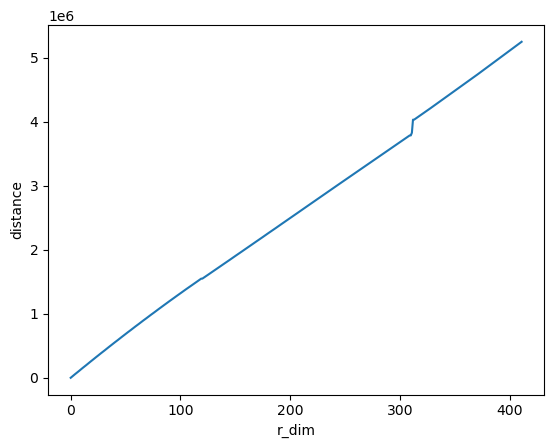

In [121]:
all_data.distance.plot()

Text(0.5, 1.0, '1985-2014 mean')

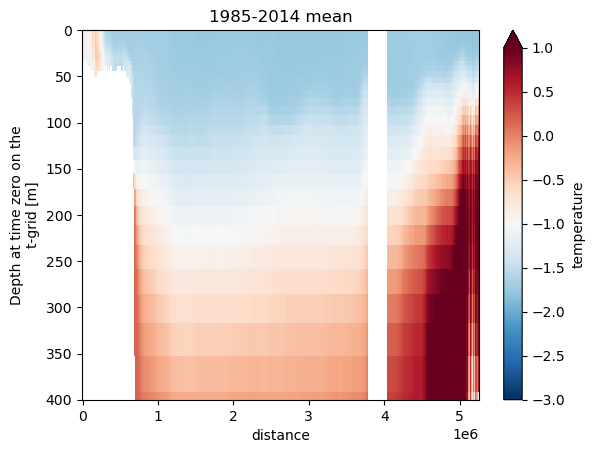

In [120]:
# It is simple to plot a scalar such as temperature along the transect:
temp_mean = all_data.temperature.mean('t_dim')
#rho_mean=all_data.rho
temp_mean.plot.pcolormesh(x='distance',y="depth_0", yincrease=False,vmin=-3,vmax=1,cmap='RdBu_r')
#(rho_mean-1000).plot.contour(x='distance',y="depth_0", yincrease=False,levels=[23.4,24,25,25.7,26.5,27.4],colors='k')
plt.ylim([400,0])
plt.title('1985-2014 mean')

Text(0.5, 1.0, '1985-2014 mean')

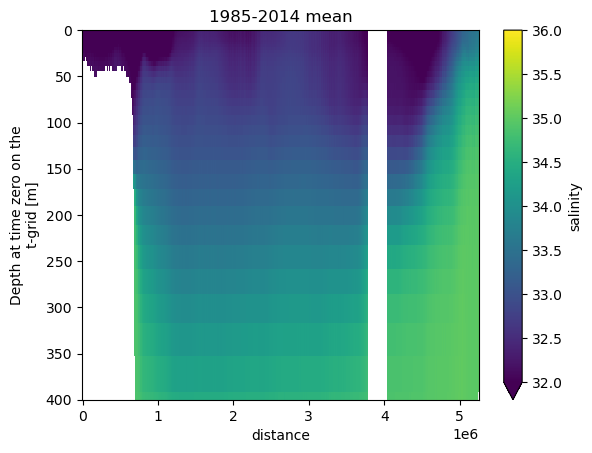

In [122]:
# It is simple to plot a scalar such as temperature along the transect:
sal_mean = all_data.salinity.mean('t_dim')
sal_mean.plot.pcolormesh(x='distance',y="depth_0", yincrease=False,vmin=32,vmax=36)
#(rho_mean-1000).plot.contour(x='distance',y="depth_0", yincrease=False,levels=[23.4,24,25,25.7,26.5,27.4],colors='k')
plt.ylim([400,0])
plt.title('1985-2014 mean')

/gws/smf/j04/canari/dask-env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 14.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Text(0.5, 0.98, '1984-2014 Mean SST')

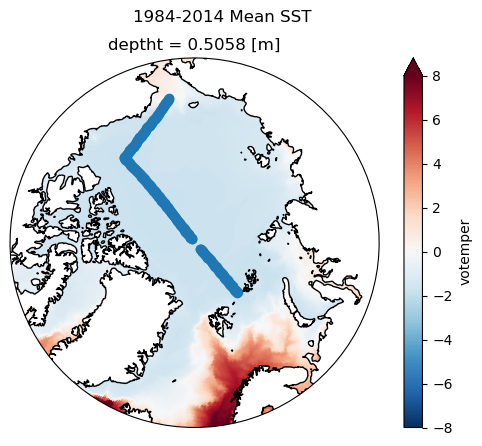

In [123]:
#tran_t = coast.TransectT(nemo_t, (90, 40), (85,40))
#tran_t = coast.TransectT(nemo_t, (75, -180), (90,-180))

import cartopy.crs as ccrs
proj=ccrs.NorthPolarStereo()
ax=plt.subplot(projection=proj)
Tdata.votemper.mean('time_counter').isel(deptht=0).plot(x='nav_lon',y='nav_lat',ax=ax,transform= ccrs.PlateCarree(),vmin=-8,vmax=8,cmap='RdBu_r')
ax.scatter(all_data.longitude,all_data.latitude,transform= ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180,180,65,90],ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
plt.suptitle('1984-2014 Mean SST')

In [ ]:
Tdata_arctic=Tdata.where(Tdata.nav_lat.load()>70,drop=True)
Tdata_arctic

In [20]:
Tdata

<xarray.Dataset>
Dimensions:              (time_counter: 360, axis_nbounds: 2, deptht: 75,
                          y: 1207, x: 1442, nvertex: 4)
Coordinates:
  * time_counter         (time_counter) object 1985-01-16 00:00:00 ... 2014-1...
  * deptht               (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * y                    (y) float64 0.0 1.0 2.0 ... 1.205e+03 1.206e+03
  * x                    (x) float64 0.0 1.0 2.0 ... 1.44e+03 1.441e+03
    nav_lat              (y, x) float32 -89.5 -89.5 -89.5 ... 50.02 50.0 50.0
    nav_lon              (y, x) float32 72.75 73.0 73.25 ... 73.01 73.0 73.0
Dimensions without coordinates: axis_nbounds, nvertex
Data variables:
    time_counter_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    deptht_bounds        (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    bounds_nav_lat       (time_counter, y, x, nvertex) float32 dask.array<chunksize=(12, 604, 721, 2), meta=np.ndarray>
    bounds_nav_lon       (time_counter, y, x, nvertex) float32 dask.array<chunksize=(12, 604, 721, 2), meta=np.ndarray>
    vosaline             (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 19, 302, 361), meta=np.ndarray>
    votemper             (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 19, 302, 361), meta=np.ndarray>
Attributes: (12/35)
    Conventions:            CF-1.10
    license:                
    institution:            NCAS
    realization_index:      1
    variant_id:             r1i1p2f1
    source_type:            AOGCM
    ...                     ...
    grid:                   Native eORCA025 tripolar primarily 1/4 deg grid; ...
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    parent_source_id:       CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3
    realm:                  ocean
    initialization_index:   1
    external_variables:     areacello

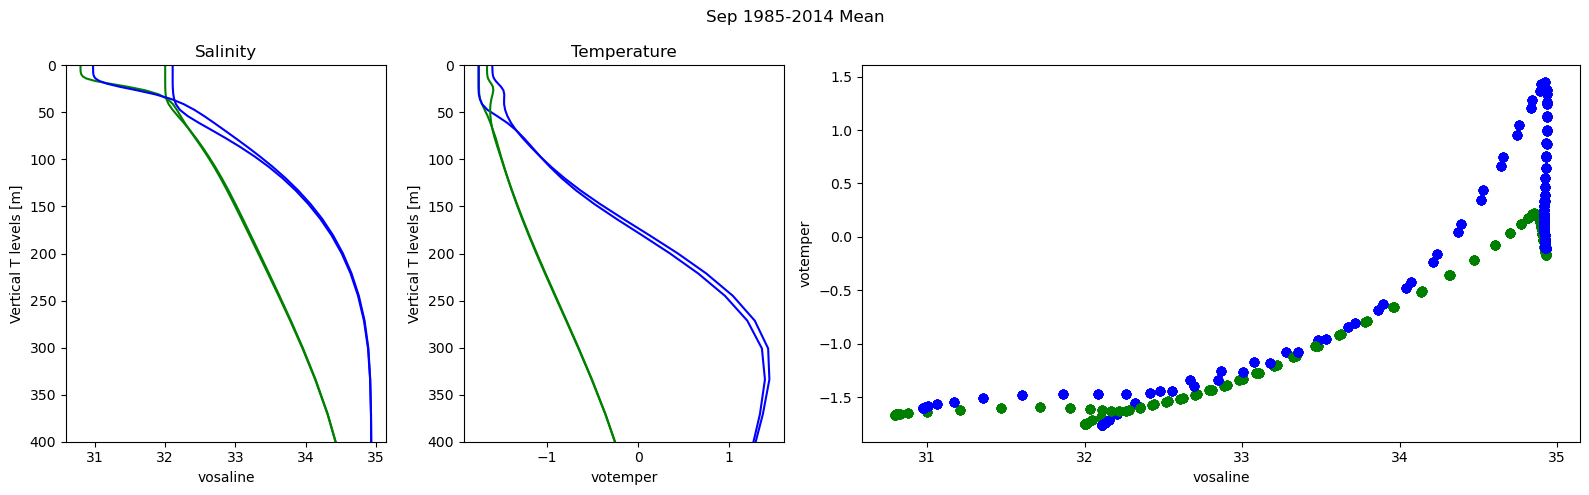

In [21]:
plot_locs=[[75,-140],[85,40]]
colors=['g','b']
mth_label=['Mar','Sep']

for im,mth in enumerate([3,9]):
    fig = plt.figure(figsize=[16,5])
    gs = fig.add_gridspec(1,4)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2:])
    for iloc,loc in enumerate(plot_locs):
        [yy,xx]=nemo_t.find_j_i(lat=loc[0],lon=loc[1])
        Tplot=Tdata.isel(x=xx,y=yy).where(Tdata.time_counter.dt.month==mth).mean('time_counter')
        Tplot.vosaline.plot(y='deptht',yincrease=False,color=colors[iloc],ax=ax1)
        ax1.set_ylim([400,0])
        ax1.set_title('Salinity')
        Tplot.votemper.plot(y='deptht',yincrease=False,color=colors[iloc],ax=ax2)
        ax2.set_ylim([400,0])
        ax2.set_title('Temperature')
        Tplot.plot.scatter(x='vosaline',y='votemper',color=colors[iloc],ax=ax3)
        ax3.set_title('')
    plt.tight_layout()
    plt.suptitle(f'{mth_label[im]} 1985-2014 Mean')